In [1]:
import numpy as np
from tqdm import tqdm
from scapy.all import *
import matplotlib.pyplot as plt
from scipy.signal import decimate
from scapy.layers.bluetooth import *
from concurrent.futures import ThreadPoolExecutor

In [2]:
# 读取 IQ 数据文件
files = "D:\\RF-Fingerprint-Extraction-for-Bluetooth\\BluetoothSignal\\signal\\ble_channel39_01.iq"
data = np.fromfile(files, dtype=np.complex64)

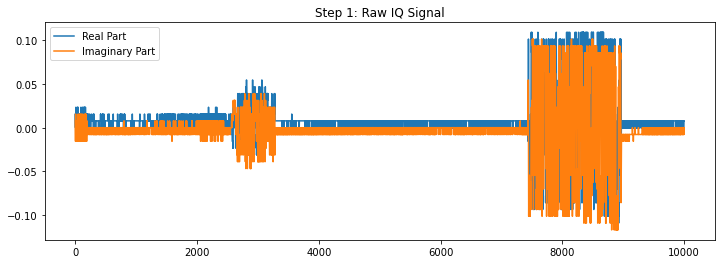

In [3]:
# 🔎 Step 1: 原始 IQ 信号（实部 & 虚部）
plt.figure(figsize=(12, 4))
plt.plot(data[:10000].real, label='Real Part')
plt.plot(data[:10000].imag, label='Imaginary Part')
plt.title("Step 1: Raw IQ Signal")
plt.legend()
plt.show()

In [4]:
# 🔎 Step 2: 解调 IQ 信号（相位差）
phase = np.angle(data)
demodulated = np.diff(phase)
demodulated = demodulated.astype(np.complex64)

C:\Users\admin\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


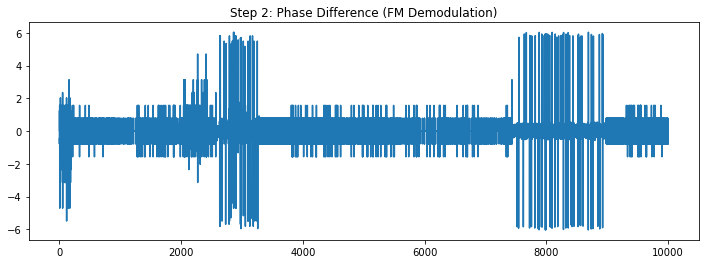

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(demodulated[:10000])
plt.title("Step 2: Phase Difference (FM Demodulation)")
plt.show()

In [6]:
# 🔎 Step 3: 采样率调整（BLE 带宽为 4MHz）
decimated = decimate(demodulated, 4)

MemoryError: Unable to allocate 14.5 GiB for an array with shape (974784764,) and data type complex128

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(decimated[:100000])
plt.title("Step 3: Downsampled Signal (4 MHz)")
plt.show()

In [ ]:
# 🔎 Step 4: 将解调后的数据转换为比特流
bits = (decimated > 0).astype(np.uint8)

In [ ]:
plt.figure(figsize=(12, 4))
plt.step(range(1000), bits[:100000], where='mid')
plt.title("Step 4: Binary Bits (0/1)")
plt.show()

In [ ]:
# 🔎 Step 5: 将比特流转换为字节流
bytes_data = np.packbits(bits).tobytes()
print(len(bytes_data))

In [ ]:
# 🔎 Step 6: 批量解析 BLE 包（并行）
def parse_packet(data_chunk):
    try:
        packet = BTLE(data_chunk)
        return packet
    except Exception:
        return None

In [ ]:
batch_size = 1000
total_packets = len(bytes_data) // 20
num_batches = total_packets // batch_size

In [ ]:
packets = []
mac_addresses = set()  # 用于存储唯一的MAC地址

with ThreadPoolExecutor(max_workers=8) as executor:
    for i in tqdm(range(num_batches), desc="Parsing BLE packets"):
        data_chunk = [bytes_data[j*20:(j+1)*20] for j in range(i*batch_size, (i+1)*batch_size)]
        results = list(executor.map(parse_packet, data_chunk))
        for pkt in results:
            if pkt and BTLE_ADV in pkt:
                mac_addresses.add(pkt.addr)
                packets.append(pkt)

In [ ]:
# 输出所有采集到的蓝牙设备的MAC地址
print("Captured MAC addresses:")
for mac in mac_addresses:
    print(mac)

In [ ]:
# 📊 Step 7: 可视化提取到的 BLE 包数量
plt.figure(figsize=(8, 4))
plt.bar(["Total Packets", "Unique MACs"], [len(packets), len(mac_addresses)], color=['#3498db', '#e74c3c'])
plt.title("Captured BLE Packets and Unique MAC Addresses")
plt.ylabel("Count")
plt.show()